In [56]:
from keras import applications
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dropout, Flatten, Dense, Activation
from keras.callbacks import CSVLogger
import tensorflow as tf
#from scipy.ndimage import imread
import numpy as np
import random
from keras.layers import LSTM
from keras.layers import Conv1D, MaxPooling1D, LeakyReLU
from keras import backend as K
import keras
from keras.callbacks import CSVLogger, ModelCheckpoint
from keras.backend.tensorflow_backend import set_session
from keras import optimizers
import h5py
from sklearn.preprocessing import MinMaxScaler
import os
import pandas as pd
import matplotlib.pyplot as plt

In [85]:
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

In [86]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))

In [87]:
with h5py.File(''.join(['bitcoin2016-12to2019-10_close.h5']), 'r') as hf:
    datas = hf['inputs'].value
    labels = hf['outputs'].value
    input_times = hf['input_times'].value
    output_times = hf['output_times'].value
    original_inputs = hf['original_inputs'].value
    original_outputs = hf['original_outputs'].value
    original_datas = hf['original_datas'].value

In [103]:
validation_datas.shape

(221, 256, 1)

In [89]:
scaler=MinMaxScaler()
#split training validation
training_size = int(0.8* datas.shape[0])
training_datas = datas[:training_size,:,:]
training_labels = labels[:training_size,:,:]
validation_datas = datas[training_size:,:,:]
validation_labels = labels[training_size:,:,:]
validation_original_outputs = original_outputs[training_size:,:,:]
validation_original_inputs = original_inputs[training_size:,:,:]
validation_input_times = input_times[training_size:,:,:]
validation_output_times = output_times[training_size:,:,:]

In [90]:
ground_true = np.append(validation_original_inputs,validation_original_outputs, axis=1)
ground_true.shape

(221, 272, 1)

In [91]:
ground_true_times = np.append(validation_input_times,validation_output_times, axis=1)
ground_true_times.shape

(221, 272, 1)

In [92]:
step_size = datas.shape[1]
batch_size= 8
nb_features = datas.shape[2]
epochs = 1

In [93]:
model = Sequential()
model.add(Conv1D(activation='relu',
input_shape=(step_size, nb_features), strides=3,
filters=8, kernel_size=8))
model.add(LeakyReLU())
model.add(Dropout(0.5))
model.add(Conv1D(activation='relu', strides=2,
filters=8, kernel_size=8))
model.add(LeakyReLU())
model.add(Dropout(0.5))
model.add(Conv1D(strides=2, filters=nb_features,
kernel_size=8))

In [94]:
model.load_weights('NewWeights/bitcoin2016-10to2019-10_close_CNN_2_relu-96-0.00018.hdf5')
model.compile(loss='mse', optimizer='adam')

In [95]:
predicted = model.predict(validation_datas)
predicted_inverted = []

# In[7]:
for i in range(original_datas.shape[1]):
    scaler.fit(original_datas[:,i].reshape(-1,1))
    predicted_inverted.append(scaler.inverse_transform(predicted[:,:,i]))
print(np.array(predicted_inverted).shape)
#get only the close data
ground_true = ground_true[:,:,0].reshape(-1)
ground_true_times = ground_true_times.reshape(-1)
ground_true_times = pd.to_datetime(ground_true_times, unit='s')
# since we are appending in the first dimension
predicted_inverted = np.array(predicted_inverted)[0,:,:].reshape(-1)
print(np.array(predicted_inverted).shape)
validation_output_times = pd.to_datetime(validation_output_times.reshape(-1), unit='s')

(1, 221, 16)
(3536,)


In [96]:
ground_true_df = pd.DataFrame()
ground_true_df['times'] = ground_true_times
ground_true_df['value'] = ground_true
ground_true_df.head()

,times,value
0,2019-03-24 18:50:00,3980.514414
1,2019-03-24 18:55:00,3981.829482
2,2019-03-24 19:00:00,3982.029881
3,2019-03-24 19:05:00,3980.956702
4,2019-03-24 19:10:00,3980.956702


In [97]:
ground_true_df = pd.DataFrame()
ground_true_df['times'] = ground_true_times
ground_true_df['value'] = ground_true
ground_true_df.set_index('times').reset_index()
ground_true_df.shape

(60112, 2)

In [98]:
prediction_df = pd.DataFrame()
prediction_df['times'] = validation_output_times
prediction_df['value'] = predicted_inverted
prediction_df.shape

(3536, 2)

In [104]:
prediction_df.head()

,times,value
3531,2019-10-19 11:30:00,7970.499512
3532,2019-10-19 11:35:00,7973.353516
3533,2019-10-19 11:40:00,7975.154785
3534,2019-10-19 11:45:00,7977.979004
3535,2019-10-19 11:50:00,7979.125488


In [100]:
prediction_df = prediction_df.loc[(prediction_df["times"].dt.year == 2019 )&(prediction_df["times"].dt.month > 1 ),: ]
ground_true_df = ground_true_df.loc[(ground_true_df["times"].dt.year == 2019 )&(ground_true_df["times"].dt.month > 1 ),:]

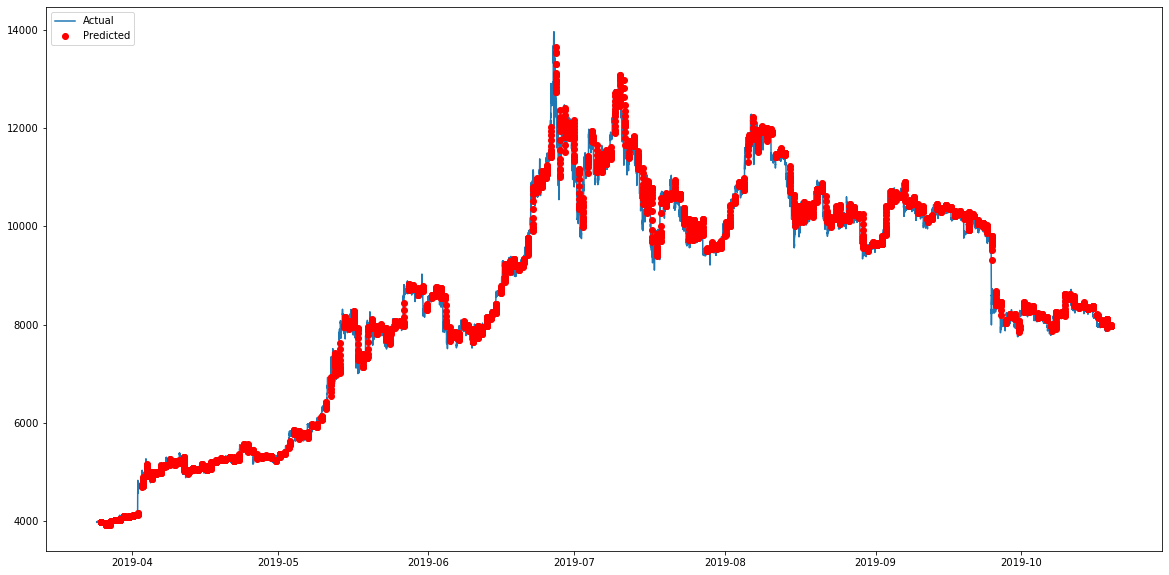

In [101]:
plt.figure(figsize=(20,10))
plt.plot(ground_true_df.times,ground_true_df.value, label = 'Actual')
plt.plot(prediction_df.times,prediction_df.value,'ro', label='Predicted')
plt.legend(loc='upper left')
plt.savefig('result_paper/bitcoin2015to2019_close_CNN_2_relu_result.png')
plt.show()

In [102]:
from sklearn.metrics import mean_squared_error
mean_squared_error(validation_original_outputs[:,:,0].reshape(-1),predicted_inverted)

66989.52750664504